In [1]:
print("hello world")

hello world


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

In [3]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [4]:
df.head(8)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   
5   5    11    12  Astrology: I am a Capricorn Sun Cap moon and c...   
6   6    13    14                                Should I buy tiago?   
7   7    15    16                     How can I be a good geologist?   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0  
5  I'm a triple Capricorn (Sun, Moon and ascendan...             1  
6  What keeps childern active and far from phone ...             0  
7          What should I do to be a great geologist?             1

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


<AxesSubplot:xlabel='is_duplicate'>

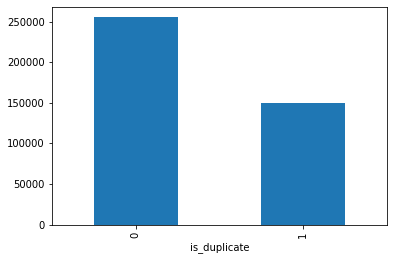

In [6]:
df.groupby('is_duplicate')['id'].count().plot.bar()

In [7]:
print('Number of question papers for training = ', len(df))

Number of question papers for training =  404290


In [8]:
perSim = round(df['is_duplicate'].mean()*100, 2)
print('Similar question pairs = {}%'.format(perSim))
print('Disimilar question pairs = {}%'.format(100-perSim))

Similar question pairs = 36.92%
Disimilar question pairs = 63.08%


### As we know there can be two or more rows having same questions so we dont have to consider them multiple times and we will just consider the unique questions 

In [9]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_once = np.sum(qids.value_counts() > 1)

print('Total number of unique questions = {}'.format(unique_qs))

print('Number of unique questions that appear more than once = {}%'.format((qs_morethan_once/unique_qs)*100))

print('Maximum number of times a question is repeated = {}'.format(max(qids.value_counts())))

Total number of unique questions = 537933
Number of unique questions that appear more than once = 20.77953945937505%
Maximum number of times a question is repeated = 157


C:\Users\Urvashi Anand\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



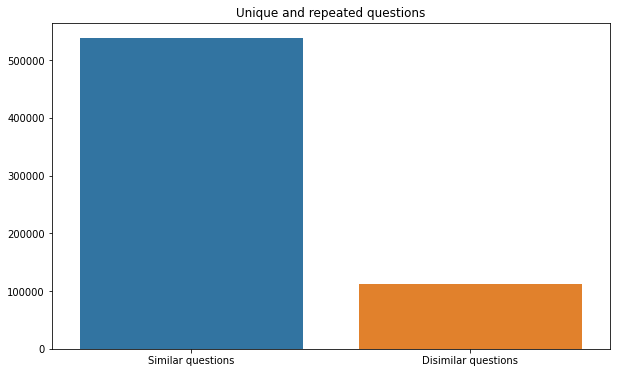

In [10]:
x = ['Similar questions', 'Disimilar questions']
y = [unique_qs, qs_morethan_once]

plt.figure(figsize=(10,6))
plt.title('Unique and repeated questions')
sns.barplot(x,y)
plt.show()

### Check for duplicates 

In [11]:
pair_duplicates = df[['qid1', 'qid2', 'is_duplicate']].groupby(['qid1', 'qid2']).count().reset_index()

print('Number of duplicate questions = ', pair_duplicates.shape[0] - df.shape[0])

Number of duplicate questions =  0


### Number of occurrences of each question

Text(0, 0.5, 'Number of questions')

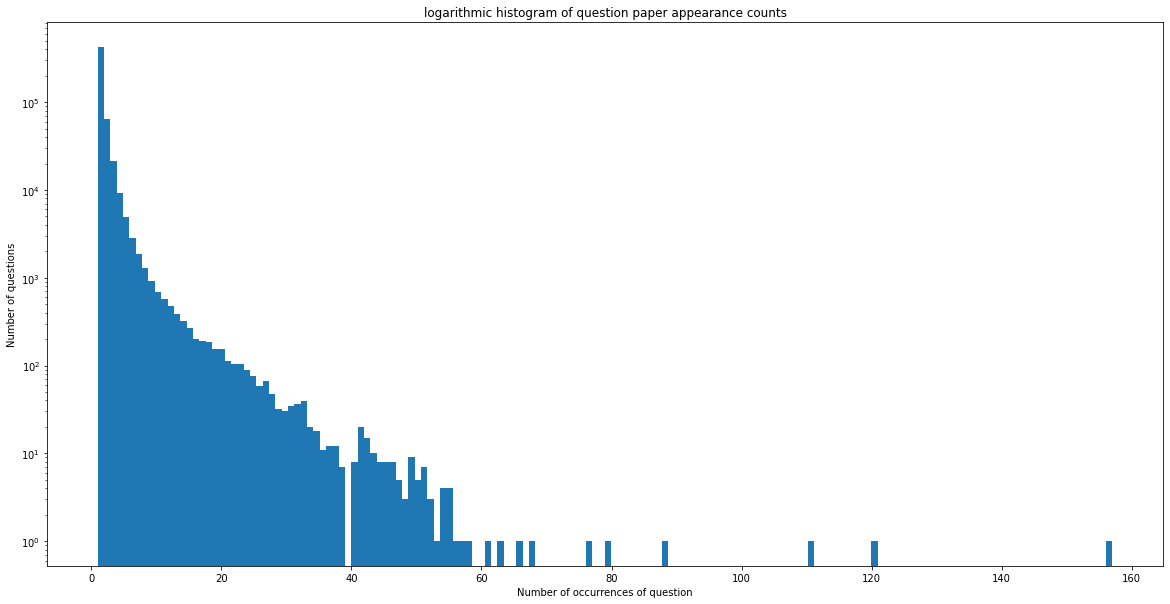

In [12]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

#non-positive values in x or y can be masked as invalid, or clipped to a very small positive number
plt.yscale('log')

plt.title("logarithmic histogram of question paper appearance counts")

plt.xlabel('Number of occurrences of question')

plt.ylabel('Number of questions')


### Checking for NULL values

In [13]:
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


- There are two rows with null values in question 2 

#### So filling the null values with ' ' 

In [14]:
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


* So now null values are filled with ' '

### Basic Feature Extraction (before cleaning)

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [22]:
#If the file contains characters which are not supported by the default encoding (known as utf-8) this can cause PANDA to generate errors. So we are using encoding='latin'

if os.path.isfile('de_fe_without_preprocessing_train.csv'):
    df = pd.read_csv('df_fe_without_preprocessing_train.csv', encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].count()
    df['freq_qid2'] = df.groupby('qid2')['qid2'].count()
    df['q1len'] = df['question1'].str.len()
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))
    
    def normalized_word_common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2)
    df['word_common'] = df.apply(normalized_word_common, axis=1)
    
    def normalized_word_total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_total, axis=1)
    
    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
        return 1.0 * len(w1 & w2) / (len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)
    
    df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1'] - df['freq_qid2'])
    
    df.to_csv('df_fe_without_preprocessing_train.csv', index=False)

df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0        NaN   
1  What would happen if the Indian government sto...             0        1.0   
2  How can Internet speed be increased by hacking...             0        NaN   
3  Find the remainder when [math]23^{24}[/math] i...             0        4.0   
4            Which fish would survive in salt water?             0        1.0   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0        NaN     66     57          14          12         10.0        23.0   
1        NaN     51     88           8          13          4.0        20.0   
2        1.0     73     59          14          10          4.0        24.0   
3        NaN     50     65          11           9          0.0        19.0   
4        1.0     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  word_common  
0    0.434783         NaN         NaN         10.0  
1    0.200000         NaN         NaN          4.0  
2    0.166667         NaN         NaN          4.0  
3    0.000000         NaN         NaN          0.0  
4    0.100000         2.0         0.0          2.0

### Analysis of some of the extracted features 

- Using Feature: q1_n_words and q2_n_words

In [16]:
print('Minimum length of the question in question1 : ', min(df['q1_n_words']))
print('Minimum length of the question in question2 : ', min(df['q2_n_words']))

print('Number of questions with minimum length [question1] :', df[df['q1_n_words'] == 1].shape[0])
print('Number of questions with minimum length [question2] :', df[df['q2_n_words'] == 1].shape[0])

Minimum length of the question in question1 :  1
Minimum length of the question in question2 :  1
Number of questions with minimum length [question1] : 67
Number of questions with minimum length [question2] : 24


- Using Feature: word_share 

C:\Users\Urvashi Anand\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Urvashi Anand\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



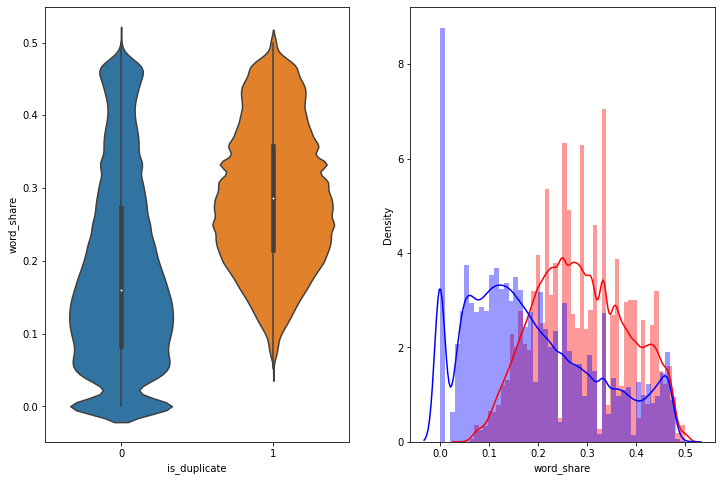

In [18]:
plt.figure(figsize=(12,8))

#suplot three arguments are = no of rows, no of columns, index of the current plot
plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:], label = '1', color='red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:], label = '0', color='blue')
plt.show()

- Using Feature: word_common

C:\Users\Urvashi Anand\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Urvashi Anand\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



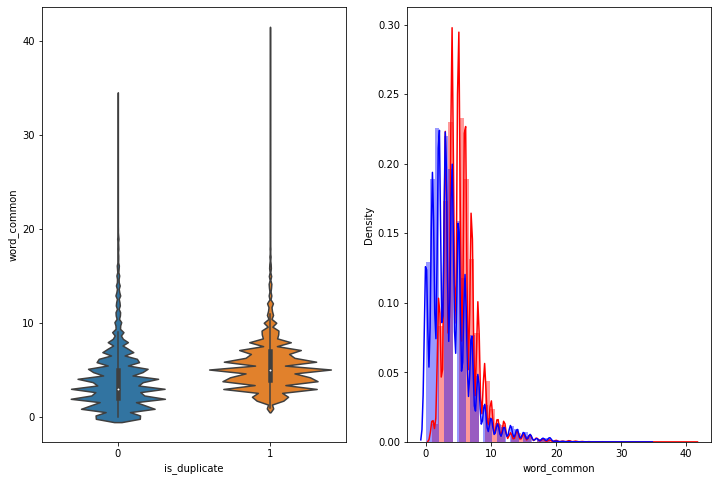

In [26]:
plt.figure(figsize=(12,8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_common'][0:], label = '1', color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_common'][0:], label = '0', color = 'blue')
plt.show()

- The distributions of the word_common feature is similar and non-similar questions are highly overlapping 

- ðŸ¥³